# Compare criteria over time

This notebook compares the various sepsis criteria over time.

Note that in this notebook, we retain "CareVue" patients, who were admitted from 2001-2008.

In [1]:
# Import libraries
from __future__ import print_function

import numpy as np
import pandas as pd
import psycopg2
import socket
import sys
import os

from collections import OrderedDict

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

In [2]:
# colours for prettier plots
import matplotlib
import matplotlib.pyplot as plt
import colorsys


from matplotlib import rcParams
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples

marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

# plot settings
%matplotlib inline
plt.style.use('ggplot')
font = {'size'   : 20}
matplotlib.rc('font', **font)
rcParams.update({'figure.autolayout': True})

# Connect to database

In [3]:
hostname=socket.gethostname()

# change username based on computer name
if hostname=='alistair-pc70':
    sqluser = 'alistairewj'
else:
    sqluser = 'postgres'

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

In [6]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

# Exclusions - applied sequentially

In [7]:
# exclusion criteria:
#   - less than 16 years old
#   - never have any chartevents data (i.e. likely administrative error)
#   - not cardiac surgery
#   - suspected of infection
#   - first ICU stay
# these exclusion criteria are created in the sepsis3_cohort table
query = query_schema + "select * from sepsis3_cohort"
co = pd.read_sql_query(query,con)

In [8]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

COL_REM = ['exclusion_nonadult',
           'exclusion_secondarystay',
           'exclusion_csurg',
           # 'exclusion_carevue', # *** WE DO NOT APPLY CAREVUE EXCLUSION ! ***
           'exclusion_early_suspicion',
           'exclusion_late_suspicion',
           'exclusion_bad_data']

idxRem = np.zeros(co.shape[0], dtype=bool)
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = True
        
print('Final non-suspected cohort size: {:g} ICU stays ({:2.2f}%).'.format(
        co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))
print('Note: the publication uses only patients from 2008-2012, which is a smaller cohort.')

Cohort - initial size: 61532 ICU stays
   8109 (13.18%) - exclusion_nonadult
  14826 (24.09%) - exclusion_secondarystay
   5905 (9.60%) - exclusion_csurg
   2738 (4.45%) - exclusion_early_suspicion
   2561 (4.16%) - exclusion_late_suspicion
    294 (0.48%) - exclusion_bad_data
Final non-suspected cohort size: 27099 ICU stays (44.04%).
Note: the publication uses only patients from 2008-2012, which is a smaller cohort.


# Load final dataset from postgres

In [9]:
# load in final dataset (already has exclusion criteria applied)
query = query_schema + "select * from sepsis3"
df = pd.read_sql_query(query,con)
df.set_index('icustay_id',inplace=True)

# apply exclusion criteria using icustay_id from co
df = df.loc[co.loc[~idxRem, 'icustay_id'],:]
df.shape[0]

27099

# Close database connection.

In [10]:
con.close()

## Add in useful variables

In [11]:
# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)

## Evaluate over time

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


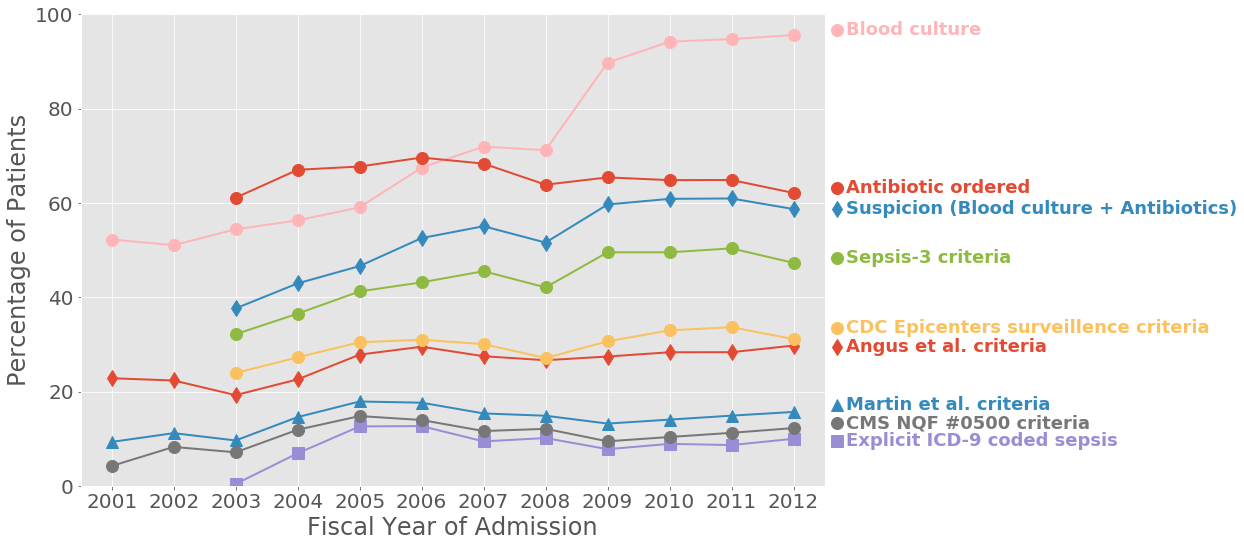

Score          	2001	2002	2003	2004	2005	2006	2007	2008	2009	2010	2011	2012
sepsis_angus   	22.8	22.3	19.2	22.6	27.8	29.5	27.5	26.6	27.4	28.3	28.3	29.8
sepsis_martin  	9.3	11.2	9.6	14.6	17.9	17.6	15.4	14.9	13.2	14.0	14.9	15.7
sepsis_explicit	0.0	0.0	0.4	6.9	12.6	12.7	9.4	10.1	7.8	8.9	8.6	10.0
sepsis_nqf     	4.2	8.3	7.1	11.9	14.8	14.0	11.6	12.1	9.4	10.4	11.2	12.2
sepsis_cdc     	0.0	0.0	23.9	27.3	30.4	31.0	30.1	27.1	30.7	33.0	33.7	31.1
sepsis-3       	0.0	0.0	32.2	36.5	41.2	43.2	45.5	42.1	49.5	49.5	50.4	47.3
blood culture  	52.3	51.1	54.4	56.3	59.1	67.5	72.0	71.2	89.8	94.2	94.8	95.6
abx_poe        	0.0	0.0	61.1	67.1	67.7	69.6	68.4	63.9	65.4	64.9	64.9	62.1
suspicion_poe  	0.0	0.0	37.6	42.9	46.6	52.6	55.1	51.6	59.7	60.9	61.0	58.7


In [12]:
if not os.path.isfile('mimiciii_fiscal_year.csv'):
    print('Cannot create plot as years are not available.')
else:
    yr = pd.read_csv('mimiciii_fiscal_year.csv')
    # set columns to lower case - also rename fiscalyear to year
    yr.columns = [x.lower() if x != 'FISCALYEAR' else 'year' for x in yr.columns]
    
    yr = yr.merge(df, how='inner', left_on='hadm_id', right_on='hadm_id')
    
    yr_keep = np.arange(2001,2013,1)
    # create a dataframe that indicates if a patient has:
    # heart rate, blood pressure, temperature, respiration rate
    # in the first day.

    sepsis = ['sepsis_angus','sepsis_martin','sepsis_explicit',
              'sepsis_nqf','sepsis_cdc',
              'sepsis-3',
              #'septic_shock_explicit', 'severe_sepsis_explicit', 'suspicion_mv',
              'blood culture', 'abx_poe', 'suspicion_poe']


    grouped = yr.loc[np.in1d(yr['year'],yr_keep),:].groupby('year')

    plt.figure(figsize=[12,8])

    # get the x-axis from the original data - right now it's plotting against 0:NUMBER_OF_YEARS
    year = np.unique(yr['year'].values)
    Y = year.size

    # set x-axis labels to years
    #ax.set_xticks(range(Y))
    #ax.set_xticklabels(year,fontsize=14)

    pretty_labels = {'sepsis_angus': 'Angus et al. criteria',
                    'sepsis_martin': 'Martin et al. criteria',
                    'sepsis_explicit': 'Explicit ICD-9 coded sepsis',
                    'sepsis_nqf': 'CMS NQF #0500 criteria',
                    'sepsis_cdc': 'CDC Epicenters surveillence criteria',
                    'septic_shock_explicit': 'ICD-9 code 785.52 (septic shock)',
                    'severe_sepsis_explicit': 'ICD-9 code 995.92 (severe sepsis)',
                    'sofa>=2': 'SOFA >= 2',
                    'sepsis-3': 'Sepsis-3 criteria',
                    'blood culture': 'Blood culture',
                    'positiveculture_poe': 'Positive culture',
                    'abx_poe': 'Antibiotic ordered',
                    'suspicion_mv': 'Blood culture + Antibiotics (IV)',
                    'suspicion_poe': 'Suspicion (Blood culture + Antibiotics)',
                    'suspicion_piv': 'Blood culture + Antibiotics (POE IV)'}
    
    # if listed here, we use a special marker
    # otherwise we just use 'o'
    marker_special = {'severe_sepsis_explicit': '^',
                      'sepsis_martin': '^',
                      'sepsis_explicit': 's',
                      'sepsis_angus': 'd',
                      'suspicion_poe': 'd'
                     }
    
    # prevent overlapping labels by changing the y_pos
    y_pos_fix = {'suspicion_poe': -1,
                'sepsis_martin': 0.4,
                'sepsis_explicit': -1.5,
                'sepsis_cdc': 1.3,
                'sepsis_angus': -1.3}
    # ===================== #
    # === PLOT THE DATA === #
    # ===================== #  
    for i, s in enumerate(sepsis):
        marker='o'
        if s in marker_special:
            marker=marker_special[s]
        # create temporary dataframe with mean proportion of criteria, indexed by time
        df_tmp = grouped.apply(lambda subf: subf[s].mean()*100.0)
        
        # if the criteria has a mean of 0, it was unavailable - don't plot it
        df_tmp = df_tmp.loc[df_tmp!=0.0]
        
        p = plt.plot(df_tmp, label=pretty_labels[s],
                linewidth=2,linestyle='-',marker=marker,markersize=12)


        # Add a text label to the right end of every line
        y_pos = yr.loc[ yr['year'] == yr_keep[-1],s ].mean()*100.0
        x_pos = 2012.85
        
        if s in y_pos_fix:
            y_pos = y_pos + y_pos_fix[s]
            
        # plot the symbol
        plt.plot(x_pos-0.15, y_pos+1.0, linestyle='',
                 color=p[0].get_color(), clip_on=False,
                 marker=marker, markersize=12)
        plt.text(x_pos, y_pos, pretty_labels[s],
                 fontsize=18, fontweight='bold',
                 color=p[0].get_color(),
                verticalalignment = 'baseline')    


    # pretty the plot
    plt.ylabel('Percentage of Patients', fontsize=24)
    #plt.legend(loc=[0.6,0.45])
    plt.xticks(yr_keep, ['{:g}'.format(x) for x in yr_keep])
    plt.ylim([0,100])
    plt.xlim([yr_keep[0]-.5,yr_keep[-1]+.5])
    plt.xlabel('Fiscal Year of Admission', fontsize=24)
    plt.savefig('SepsisOverTime.eps', dpi=300, bbox_inches='tight')
    
    plt.show()
    # print table
    print('{:15s}'.format('Score'),end='')
    for i, y in enumerate(yr_keep):
        print('\t{:g}'.format(y),end='')
    print('')
    
    for i, s in enumerate(sepsis):
        print('{:15s}'.format(s),end='')
        for y in yr_keep:
                print('\t{:2.1f}'.format( np.sum(yr.loc[yr['year']==y,s])*100.0/np.sum(yr['year']==y)),end='')
        print('')